<a href="https://colab.research.google.com/github/psbhargava/CarDamaged-Classification-Assessment/blob/master/1_Check_Damaged_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12959014530160860701, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4530459437328399835
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8566293338283387279
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2098185818599360377
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import os
import json
import urllib
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


from keras import optimizers
from keras import applications
from keras.models import Sequential, Model 
from keras.models import Sequential,load_model
from keras.callbacks import ModelCheckpoint, History
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
!wget https://car-damage-datasets.s3.amazonaws.com/data1a.zip

--2020-04-25 02:57:51--  https://car-damage-datasets.s3.amazonaws.com/data1a.zip
Resolving car-damage-datasets.s3.amazonaws.com (car-damage-datasets.s3.amazonaws.com)... 52.216.104.59
Connecting to car-damage-datasets.s3.amazonaws.com (car-damage-datasets.s3.amazonaws.com)|52.216.104.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128541538 (123M) [application/zip]
Saving to: ‘data1a.zip’

data1a.zip          100%[===================>] 122.59M  35.0MB/s    in 4.1s    

2020-04-25 02:57:56 (30.1 MB/s) - ‘data1a.zip’ saved [128541538/128541538]



In [0]:
! unzip data1a.zip

Archive:  data1a.zip
   creating: train/
   creating: train/damage/
  inflating: train/damage/0001.JPEG  
  inflating: train/damage/0002.JPEG  
  inflating: train/damage/0003.JPEG  
  inflating: train/damage/0004.JPEG  
  inflating: train/damage/0005.JPEG  
  inflating: train/damage/0006.JPEG  
  inflating: train/damage/0007.JPEG  
  inflating: train/damage/0008.JPEG  
  inflating: train/damage/0009.JPEG  
  inflating: train/damage/0010.JPEG  
  inflating: train/damage/0011.JPEG  
  inflating: train/damage/0012.JPEG  
  inflating: train/damage/0013.JPEG  
  inflating: train/damage/0014.JPEG  
  inflating: train/damage/0015.JPEG  
  inflating: train/damage/0016.JPEG  
  inflating: train/damage/0017.JPEG  
  inflating: train/damage/0018.JPEG  
  inflating: train/damage/0019.JPEG  
  inflating: train/damage/0020.JPEG  
  inflating: train/damage/0021.JPEG  
  inflating: train/damage/0022.JPEG  
  inflating: train/damage/0023.JPEG  
  inflating: train/damage/0024.JPEG  
  inflating: train/d

In [0]:
img_width = 256
img_height = 256
train_data_dir = '/content/train'
valid_data_dir = '/content/valid'
fine_tuned_model_path = 'ft_model.h5'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
print(nb_train_samples)

validation_samples = [len(os.listdir(valid_data_dir+'/'+i)) for i in sorted(os.listdir(valid_data_dir))]
nb_validation_samples = sum(validation_samples)
print(nb_validation_samples)

epochs = 50 #50
batch_size = 8

1840
460


In [0]:
model = applications.DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


74842112/74836368 [==============================] - 3s 0us/step


In [0]:
for layer in model.layers[:25]:
    layer.trainable = False

In [0]:
x = model.output

x = Flatten()(x)
x = Dense(256, activation="relu")(x)

x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)

predictions = Dense(1, activation="sigmoid")(x)

In [0]:
model_final = Model(input = model.input, output = predictions)

model_final.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

train_datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip = True,fill_mode = "nearest",zoom_range = 0.2,
                                   width_shift_range = 0.2,height_shift_range=0.2,shear_range=0.2,rotation_range=40)

test_datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip = True,fill_mode = "nearest",zoom_range = 0.2,
                                  width_shift_range = 0.2,height_shift_range=0.2,shear_range=0.2,rotation_range=40)

train_generator = train_datagen.flow_from_directory(train_data_dir,target_size = (img_height, img_width),batch_size = batch_size, 
                                                    class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(valid_data_dir,target_size = (img_height, img_width),
                                                        class_mode = "binary")

checkpoint = ModelCheckpoint("Damaged_densenet_final.h5", monitor='val_acc', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

model_final.fit_generator(train_generator,samples_per_epoch = nb_train_samples,epochs = epochs,
                          validation_data = validation_generator,nb_val_samples = nb_validation_samples,
                          callbacks = [checkpoint]) #,early

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=50, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=230, validation_steps=460)`



Epoch 1/50
230/230 [==============================] - 328s 1s/step - loss: 0.6883 - accuracy: 0.5902 - val_loss: 0.4817 - val_accuracy: 0.7732
Epoch 2/50


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


230/230 [==============================] - 290s 1s/step - loss: 0.5175 - accuracy: 0.7462 - val_loss: 0.4719 - val_accuracy: 0.8265
Epoch 3/50
230/230 [==============================] - 289s 1s/step - loss: 0.4402 - accuracy: 0.7946 - val_loss: 0.2822 - val_accuracy: 0.8411
Epoch 4/50
230/230 [==============================] - 288s 1s/step - loss: 0.4238 - accuracy: 0.8185 - val_loss: 0.3309 - val_accuracy: 0.8635
Epoch 5/50
230/230 [==============================] - 289s 1s/step - loss: 0.4034 - accuracy: 0.8136 - val_loss: 0.2880 - val_accuracy: 0.8576
Epoch 6/50
230/230 [==============================] - 292s 1s/step - loss: 0.3823 - accuracy: 0.8310 - val_loss: 0.2162 - val_accuracy: 0.8750
Epoch 7/50
230/230 [==============================] - 293s 1s/step - loss: 0.3635 - accuracy: 0.8418 - val_loss: 0.2781 - val_accuracy: 0.8773
Epoch 8/50
230/230 [==============================] - 294s 1s/step - loss: 0.3558 - accuracy: 0.8554 - val_loss: 0.4064 - val_accuracy: 0.8818
Epoch 9/50

KeyboardInterrupt: ignored

In [0]:
def car_categories_gate(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    plt.imshow(img)
    plt.show()
    print ("Validating that damage exists...")
    print (pred)
    if pred[0][0] <=.5:
        print ("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")

In [0]:
model_final.save_weights("Damaged_densenet_final.h5.h5")

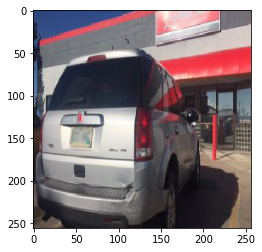

Validating that damage exists...
[[0.90782684]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [0]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', model_final)

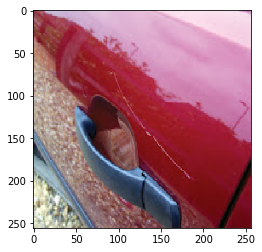

Validating that damage exists...
[[0.17453039]]
Validation complete - proceed to location and severity determination


In [0]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', model_final)

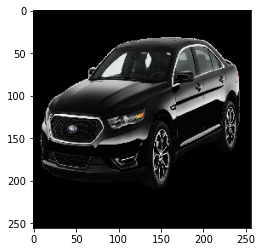

Validating that damage exists...
[[0.99969935]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [0]:
car_categories_gate('https://st.motortrend.com/uploads/sites/10/2017/02/2017-ford-taurus-sho-sedan-angular-front.png', model_final)

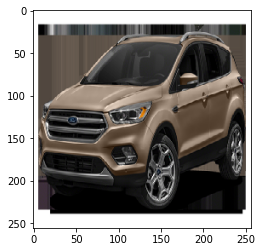

Validating that damage exists...
[[0.9966813]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [0]:
car_categories_gate('https://www.cars.com/cstatic-images/car-pictures/xl/usc70fos131c021001.png',model_final)

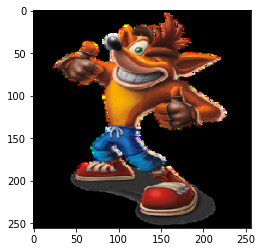

Validating that damage exists...
[[0.9155464]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [0]:
car_categories_gate('https://upload.wikimedia.org/wikipedia/en/thumb/1/16/Crash_Bandicoot.png/220px-Crash_Bandicoot.png',model_final)

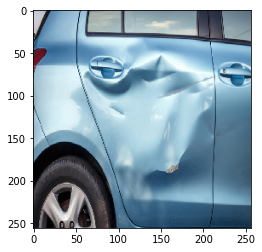

Validating that damage exists...
[[0.0947215]]
Validation complete - proceed to location and severity determination


In [0]:
car_categories_gate('https://boygeniusreport.files.wordpress.com/2017/09/dented-car.jpg?quality=98&strip=all&w=782',model_final)

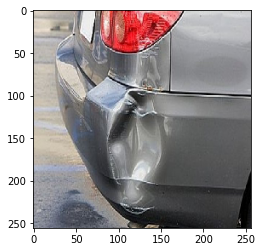

Validating that damage exists...
[[0.15049656]]
Validation complete - proceed to location and severity determination


In [0]:
car_categories_gate('https://img-aws.ehowcdn.com/600x400/cpi.studiod.com/www_ehow_com/i.ehow.com/images/a02/7p/bi/repair-car-dent-800x800.jpg',model_final)

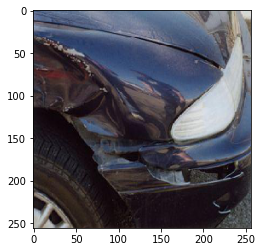

Validating that damage exists...
[[0.07628665]]
Validation complete - proceed to location and severity determination


In [0]:
car_categories_gate('https://cf.ltkcdn.net/cars/images/std/71228-400x284-Cardents.jpg',model_final)

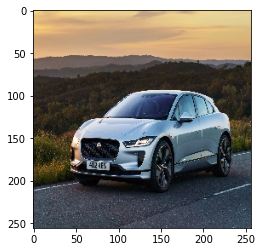

Validating that damage exists...
[[0.99983776]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [0]:
car_categories_gate('https://media.wired.com/photos/5b86fce8900cb57bbfd1e7ee/master/pass/Jaguar_I-PACE_S_Indus-Silver_065.jpg',model_final)

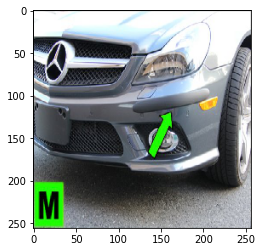

Validating that damage exists...
[[0.8701246]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [0]:
car_categories_gate('https://images-na.ssl-images-amazon.com/images/I/51dhUSCzBfL.jpg',model_final)

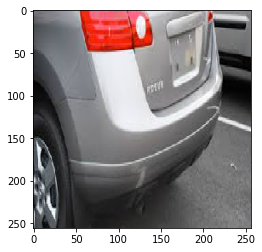

Validating that damage exists...
[[0.21165669]]
Validation complete - proceed to location and severity determination


In [0]:
car_categories_gate('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpG_0UHGpCG8FE9ggGu2YOx39eBgJnTIDEUmS6g5V38Ltfn7Mz',model_final)